In [1]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import scipy
from scipy.stats import ttest_1samp, pearsonr
from scipy.io import loadmat
from sklearn.metrics import r2_score
import seaborn as sns
import h5py

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting, image
from nipype.interfaces import fsl

In [3]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/home/sungbeenpark/github'

In [4]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [5]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [6]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [7]:
dname = join(dir_git,'Functional_Fusion')
sys.path.append(dname)
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

In [8]:
dname = join(dir_git,'fracridge')
sys.path.append(dname)
from fracridge import fracridge

In [9]:
dname = join(dir_git,'GLMsingle')
sys.path.append(dname)
import glmsingle
from glmsingle.glmsingle import getcanonicalhrflibrary
from glmsingle.utils.squish import squish

In [10]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import plot as splt
from SSS import image as simage
from SSS import glmsingle as ssingle

---

In [11]:
list_run = su.get_list_run()
list_run

['r01', 'r02', 'r03', 'r04', 'r05', 'r06', 'r07', 'r08']

In [12]:
hem = 'L'
list_roi = simage.get_list_roi()
list_roi

array(['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp'], dtype='<U4')

---

In [13]:
glm = 1
dir_glm = ssingle.get_dir_glmsingle(glm)
dir_glm

'/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/glm_1'

In [14]:
dir_roi = join(dir_glm,'ROI')

---

### HRF library

In [15]:
stimdur = 2
tr = 1

(20, 52)


<Axes: >

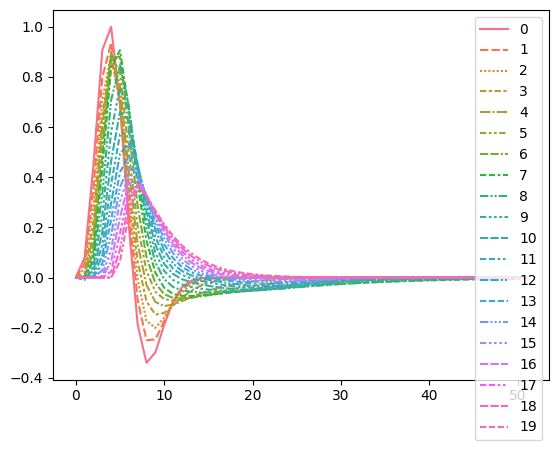

In [16]:
hrflib = getcanonicalhrflibrary(stimdur,tr)
print(hrflib.shape)
sns.lineplot(hrflib.T)

---

In [17]:
subj = 'S01'

In [18]:
roi = 'S1'

### $y_{raw}$ : $(T \times P)$

In [19]:
y_raw = simage.load_yraw(subj=subj, roi=roi, hemi=hem)
y_raw = simage.trim_ydata(ydata=y_raw, subj=subj, glm=glm, as_nii=False)
y_raw.shape

(3256, 1114)

In [48]:
df_a = pd.melt(
    frame=pd.DataFrame(y_raw).reset_index(),
    id_vars='index',
    value_vars=np.arange(y_raw.shape[-1]), value_name='value',
    var_name='voxel',
    ignore_index=True
)
df_a['hue'] = 'y_raw'
df_a

,index,voxel,value,hue
0,0,0,104.670990,y_raw
1,1,0,113.757904,y_raw
2,2,0,113.929352,y_raw
3,3,0,110.971825,y_raw
4,4,0,105.956871,y_raw
...,...,...,...,...
3627179,3251,1113,231.314117,y_raw
3627180,3252,1113,236.747208,y_raw
3627181,3253,1113,232.672394,y_raw
3627182,3254,1113,229.774734,y_raw


---

### GLMsingle

$HRF$: $(P \times 1)$  
$R^{2}$: $(P \times 1)$  
$\beta$: $(K \times P)$

In [22]:
list_map = ['R2','HRF','BETA']
list_dtype = ['dscalar','dscalar','dtseries']

In [23]:
cii = {}
for m, d in zip(list_map, list_dtype):
    fname = join(dir_roi,'cifti.%s.%s.%s.%s.%s.nii'%(hem,subj,roi,m,d))
    cii[m] = nb.load(fname)
cii

{'R2': <nibabel.cifti2.cifti2.Cifti2Image at 0x774405c82280>,
 'HRF': <nibabel.cifti2.cifti2.Cifti2Image at 0x774405d58790>,
 'BETA': <nibabel.cifti2.cifti2.Cifti2Image at 0x774405d511f0>}

In [24]:
cii['BETA'].get_fdata().shape

(544, 1114)

---

### Design Matrix : $(T \times K)$

In [25]:
design = ssingle.get_designSINGLE(subj=subj, glm=glm, run=None)
design.shape

(3256, 544)

In [44]:
yhat_map = []
for idx_voxel, idx_hrf in enumerate(tqdm(cii['HRF'].get_fdata()[0].astype(int))):
    hrf = hrflib[idx_hrf-1]
    design_conv = scipy.signal.convolve2d(design, hrf[:,np.newaxis], mode='same')
    y_hat = design_conv @ cii['BETA'].get_fdata()[:,idx_voxel]
    yhat_map.append(y_hat)
yhat_map = np.array(yhat_map)
yhat_map = yhat_map.T

100%|███████████████████████████████████████████████| 1114/1114 [07:00<00:00,  2.65it/s]


In [65]:
df_b = pd.melt(
    frame=pd.DataFrame(yhat_map).reset_index(),
    id_vars='index',
    value_vars=np.arange(yhat_map.shape[-1]), value_name='value',
    var_name='voxel',
    ignore_index=True
)
df_b['hue'] = 'y_hat'
df_b

,index,voxel,value,hue
0,0,0,0.935514,y_hat
1,1,0,1.415838,y_hat
2,2,0,1.380547,y_hat
3,3,0,0.946763,y_hat
4,4,0,-0.069600,y_hat
...,...,...,...,...
3627179,3251,1113,-0.000053,y_hat
3627180,3252,1113,-0.000032,y_hat
3627181,3253,1113,-0.000019,y_hat
3627182,3254,1113,-0.000011,y_hat


---

In [66]:
df_y = pd.concat([df_a, df_b])
df_y

,index,voxel,value,hue
0,0,0,104.670990,y_raw
1,1,0,113.757904,y_raw
2,2,0,113.929352,y_raw
3,3,0,110.971825,y_raw
4,4,0,105.956871,y_raw
...,...,...,...,...
3627179,3251,1113,-0.000053,y_hat
3627180,3252,1113,-0.000032,y_hat
3627181,3253,1113,-0.000019,y_hat
3627182,3254,1113,-0.000011,y_hat


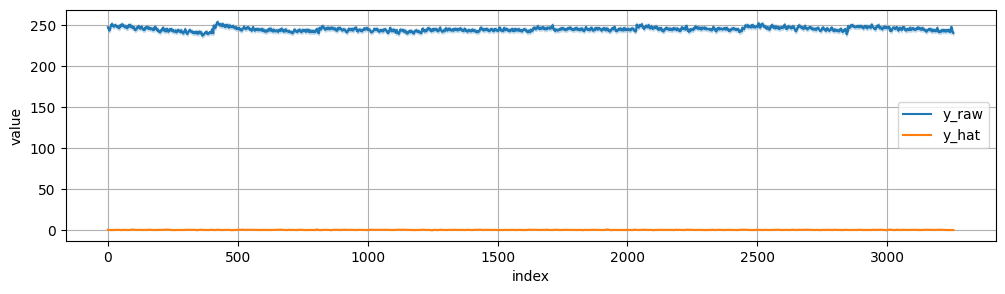

In [67]:
fig, ax = plt.subplots(figsize=(12,3))
g = sns.lineplot(
    data=df_y,
    x='index', y='value', hue='hue',
    estimator='mean', errorbar='se',
    ax=ax
)
g.grid()
g.legend()